# Image Processing

José Luis Lobera del Castillo <br>
José Miguel de la Mora Álvarez <br>
Rafael Andrade Ruíz Capetillo

In [173]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
from skimage import exposure
import nose.tools
import scipy.misc
import scipy.ndimage
import skimage.filters
from PIL import Image
from collections import deque


### Part 1

1.1 Download the Girl Face image and plot a histogram of the grey levels it contains. (Try plotting a histogram of another grey scale image and comparing the difference) (5 points)

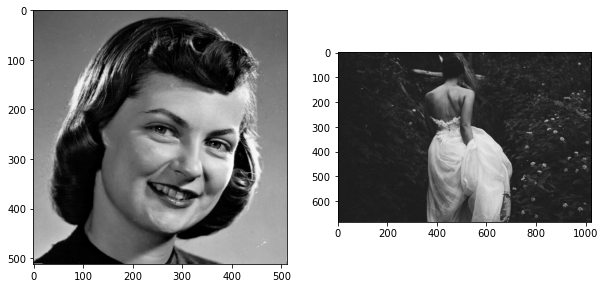

In [22]:
imageGirl = cv2.imread('Girl Face.png', 0)
imageBride = cv2.imread('boda.jpeg', 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imageGirl, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imageBride, cmap='gray')


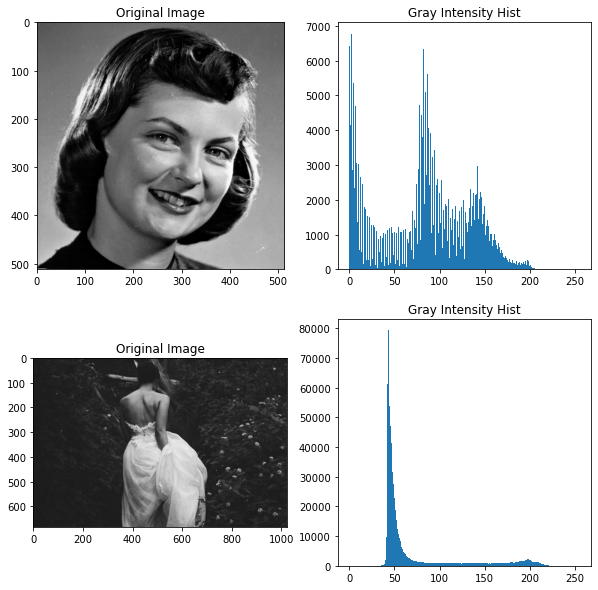

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(imageGirl,cmap='gray')

plt.subplot(2,2,2)
plt.title('Gray Intensity Hist')
plt.hist(imageGirl.ravel(),256,[0,255])

plt.subplot(2,2,3)
plt.title('Original Image')
plt.imshow(imageBride,cmap='gray')

plt.subplot(2,2,4)
plt.title('Gray Intensity Hist')
plt.hist(imageBride.ravel(),256,[0,255])

plt.show()

1.2 Write a short program to threshold the image and try to identify a good threshold by trial and error. Create a ground truth segmentation. (15 points)

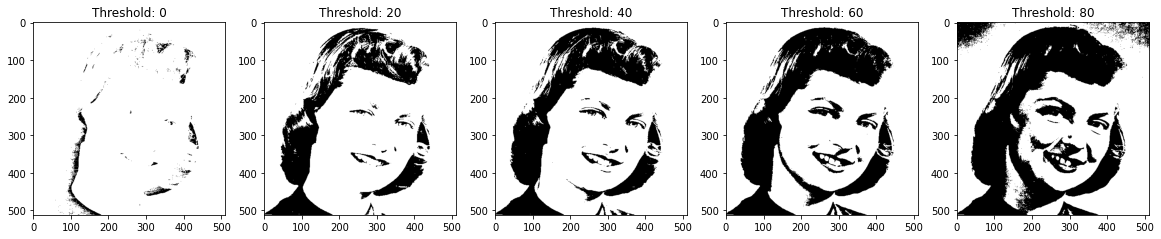

In [11]:
thresholds = np.array(list(range(0, 100, 20)))

plt.figure(figsize=(20,5))

for i, threshold in enumerate(thresholds):
    binary_mask = imageGirl > threshold

    plt.subplot(1,5,i+1)
    plt.imshow(binary_mask, cmap="gray")
    plt.title('Threshold: ' + str(threshold))

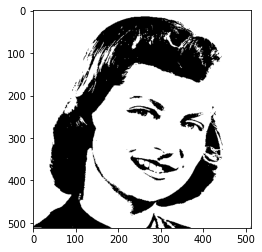

In [12]:
thresholdGirl = imageGirl > 50

plt.figure()
plt.imshow(thresholdGirl, cmap="gray")
plt.show()

1.3 Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm. What threshold does the ROC curve suggest? You may have to implement an algorithm to find the point closest to a desired Operating Point. How does it compare to your trial and error estimate? (30 points)

True
80


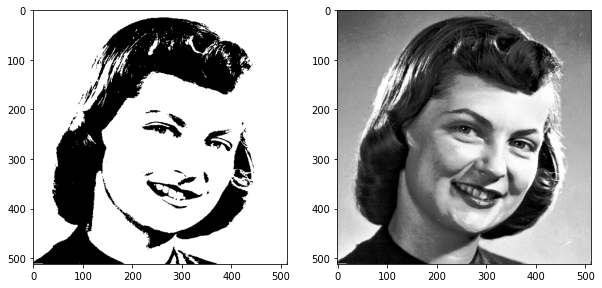

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score,auc



ground_truth = exposure.equalize_hist(imageGirl, nbins=256)
ground_truth = (ground_truth * 255).astype(int)
#y = cv2.threshold(imageGirl, 50, 255, cv2.THRESH_BINARY_INV)[1]
print(thresholdGirl[0,0])
print(ground_truth[0,0])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(thresholdGirl, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(ground_truth, cmap="gray")

plt.show()


#fpr, tpr, thresholds = roc_curve(np.binary_repr(ground_truth), np.binary_repr(thresholdGirl))

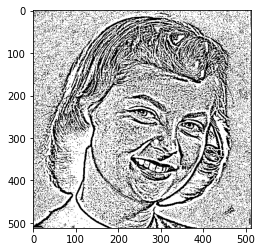

In [14]:
#Image for comparing the selected threshold

th3 = cv2.adaptiveThreshold(imageGirl,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.figure()
plt.imshow(th3,cmap="gray")
plt.show()

In [15]:
th4=(th3/255).astype("int")
print(th4)
score_value = th4.ravel() # we want to make them into vectors
ground_truth_labels = thresholdGirl.ravel() # we want to make them into vectors
fpr, tpr, jiji = roc_curve(ground_truth_labels,score_value)
print(imageGirl.shape)
roc_auc = auc(fpr,tpr)


[[1 1 1 ... 1 1 0]
 [1 0 1 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
(512, 512)


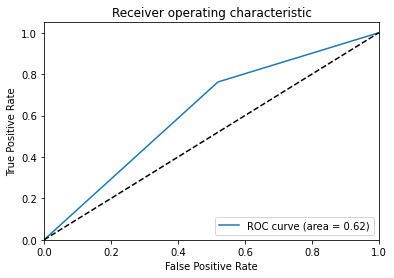

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

#### Part 2

2.1 Implement a region growing algorithm and compare its performance at segmenting the face in 
the image above with the performance of the thresholding algorithm. Show the seeds you chose. 
(25 points)

In [169]:
matrix=np.zeros_like(imageGirl,dtype="int")
matrix=imageGirl

def CompareBounds(x,y):
    max_y=matrix.shape[0]
    max_x=matrix.shape[1]
    if x>=0 and x<max_x and y>=0 and y<max_y:
        return True
    else:
        return False

In [174]:
#Reinicio
region_matrix=np.zeros_like(imageGirl,dtype="int")
bool_matrix=np.zeros_like(imageGirl,dtype="int")

In [175]:
def RegionGrowingStack(sx,sy,md=22,nr=255):

    stack=deque()
    bv=matrix[sx,sy]
    stack.append([sx,sy])

    while stack:
        seedx,seedy=stack.popleft()
        if CompareBounds(seedx,seedy)==False: 
            continue
        if bool_matrix[seedx,seedy]==1:
            continue
        if int(abs(int(matrix[seedx,seedy])-bv))>md:
            continue
        bv=matrix[seedx,seedy]
        bool_matrix[seedx,seedy]=1
        region_matrix[seedx,seedy]=nr

        stack.appendleft([seedx-1,seedy])
        stack.appendleft([seedx+1,seedy])
        stack.appendleft([seedx,seedy-1])
        stack.appendleft([seedx,seedy+1])

In [176]:
RegionGrowingStack(12,12)
RegionGrowingStack(250,250)
RegionGrowingStack(500,500)

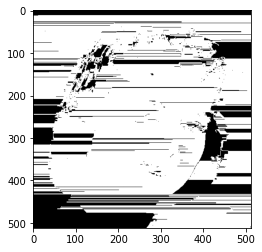

In [181]:
plt.figure()
plt.imshow(region_matrix,cmap="gray")
plt.show()

2.2 Implement the mean-shift algorithm and show the results that you achieve for different values 
of the “radius” parameter. (25 points)

In [182]:
def euclideanDist(x, c):
    return np.sqrt(np.sum((x-c)**2))

def gaussianKernel(dist, epsilon):
    return ( 1/(epsilon * np.sqrt(2*np.pi))) * np.exp(-0.5*((dist/epsilon))**2)

def neighborhood(X, centroid, epsilon):
    inNeighborhood = []

    for x in X:
        dist = euclideanDist(x, centroid)
        if dist <= epsilon:
            inNeighborhood.append(x)

    return inNeighborhood


In [183]:
epsilon = 16
maxIter = 25
centroids = []

(512, 512)
(30, 30)
(900,)


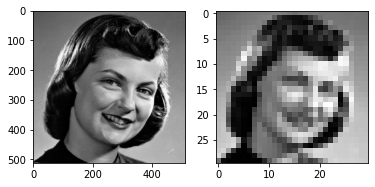

In [184]:
imageGirl = cv2.imread('Girl Face.png', 0)
miniImage = cv2.resize(imageGirl, (30, 30), interpolation = cv2.INTER_AREA)
flatImage = miniImage.flatten()

print(imageGirl.shape)
print(miniImage.shape)
print(flatImage.shape)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imageGirl, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(miniImage, cmap='gray')

Mean Shift Algorithm

In [185]:
for _ in range(maxIter):
    for i in range(len(flatImage)):
        neighbors = neighborhood(flatImage, flatImage[i], epsilon)
        num = 0
        den = 0

        for neighbor in neighbors:
            dist = euclideanDist(neighbor, flatImage[i])
            weight = gaussianKernel(dist, epsilon)
            num += weight * neighbor
            den += weight

        flatImage[i] = num/den

centroids = np.copy(flatImage)

<ipython-input-182-11f97f269ae6>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  return np.sqrt(np.sum((x-c)**2))


In [186]:
labels = []

for x in flatImage:
    distances = [euclideanDist(x, center) for center in centroids]
    labels.append(distances.index(min(distances)))


<ipython-input-182-11f97f269ae6>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  return np.sqrt(np.sum((x-c)**2))


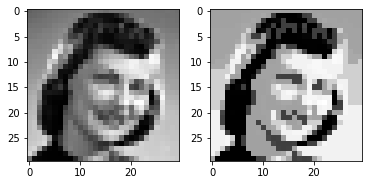

In [187]:
finalImage = centroids.reshape(30,30)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(miniImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(finalImage, cmap='gray')